# 앙상블 회귀

## (공통) 데이터 로딩 및 분할

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv('./dataset/HousingData.csv')

In [3]:
df = df.ffill()  # 바로 앞 데이터로 결측치 제거

In [4]:
x = df.drop('MEDV', axis=1)
y = df['MEDV']

x = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)

## Voting
- 동일 데이터셋에 대해 서로 다른 회귀 모형 알고리즘을 사용하여 각 모델의 예측 결과의 평균값을 반환한다.

### 패키지 로딩

In [5]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import VotingRegressor

### 모델 생성

In [6]:
lasso = Lasso(alpha=0.05)
ridge = Ridge(alpha=1)
linear = LinearRegression()
vo_r = VotingRegressor(estimators=[('Lasso', lasso), ('Ridge', ridge), ('Linear', linear)])

### 학습 및 평가

In [7]:
vo_r.fit(x_train, y_train)
y_hat = vo_r.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score:{r2_score(y_test, y_hat):.3f}')

RMSE:4.988
R2 Score:0.748


### 개별 회귀모형 학습 결과 비교

In [8]:
estimators = [('Lasso', lasso), ('Ridge', ridge), ('Linear', linear)]
for name, model in estimators:
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    print(f'{name} 모델 RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
    print(f'{name} 모델 R2 Score:{r2_score(y_test, y_hat):.3f}')
    print('='*30)

Lasso 모델 RMSE:5.021
Lasso 모델 R2 Score:0.745
Ridge 모델 RMSE:4.978
Ridge 모델 R2 Score:0.749
Linear 모델 RMSE:4.976
Linear 모델 R2 Score:0.749


## Boosting

### AdaBoost

#### 패키지 로딩

In [9]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#### 모델 생성

In [10]:
ada_r = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=0)

#### 학습 및 평가

In [11]:
ada_r.fit(x_train, y_train)
y_hat = ada_r.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.606
R2 Score:0.868


### GradientBoost

#### DecisionTreeRegressor를 활용한 GradientBoosting 원리 이해

In [12]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(10)
x_ = np.random.rand(100, 1) - 0.5  # [-0.5, 0.5) 범위 데이터 100x1 모양으로 생성
y_ = 3 * x_[:,0]**2 + 0.05*np.random.randn(100)  # y = 3x^2 + noise

In [13]:
y_[:3]

array([0.27623009, 0.70126328, 0.05048995])

In [14]:
tree_reg1 = DecisionTreeRegressor(max_depth=3, random_state=10)
tree_reg1.fit(x_, y_)

DecisionTreeRegressor(max_depth=3, random_state=10)

- 이전 예측기가 만든 잔여 오차에 대해 다음 의사결정 나무 모형이 학습한다.

In [15]:
y2 = y_ - tree_reg1.predict(x_)  # 첫 번째 모델에 의해 만들어진 오차
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=11)
tree_reg2.fit(x_, y2)

DecisionTreeRegressor(max_depth=3, random_state=11)

In [16]:
y3 = y2 - tree_reg2.predict(x_)
tree_reg3 = DecisionTreeRegressor(max_depth=3, random_state=12)
tree_reg3.fit(x_, y3)

DecisionTreeRegressor(max_depth=3, random_state=12)

- 새로운 샘플에 대한 예측을 만들려면 모든 모델의 예측을 더한다.

In [17]:
# y = 3x^2 + noise
# x = -0.4, y = 0.48 + a
# x = 0.0, a(noise)
# x = 0.5, y = 0.75 + a
x_new  = np.array([[-0.4],[0.],[0.5]])
result = np.sum(model.predict(x_new) for model in (tree_reg1, tree_reg2, tree_reg3))
print(result)

[0.48433793 0.02328039 0.67494791]


- 결과 시각화

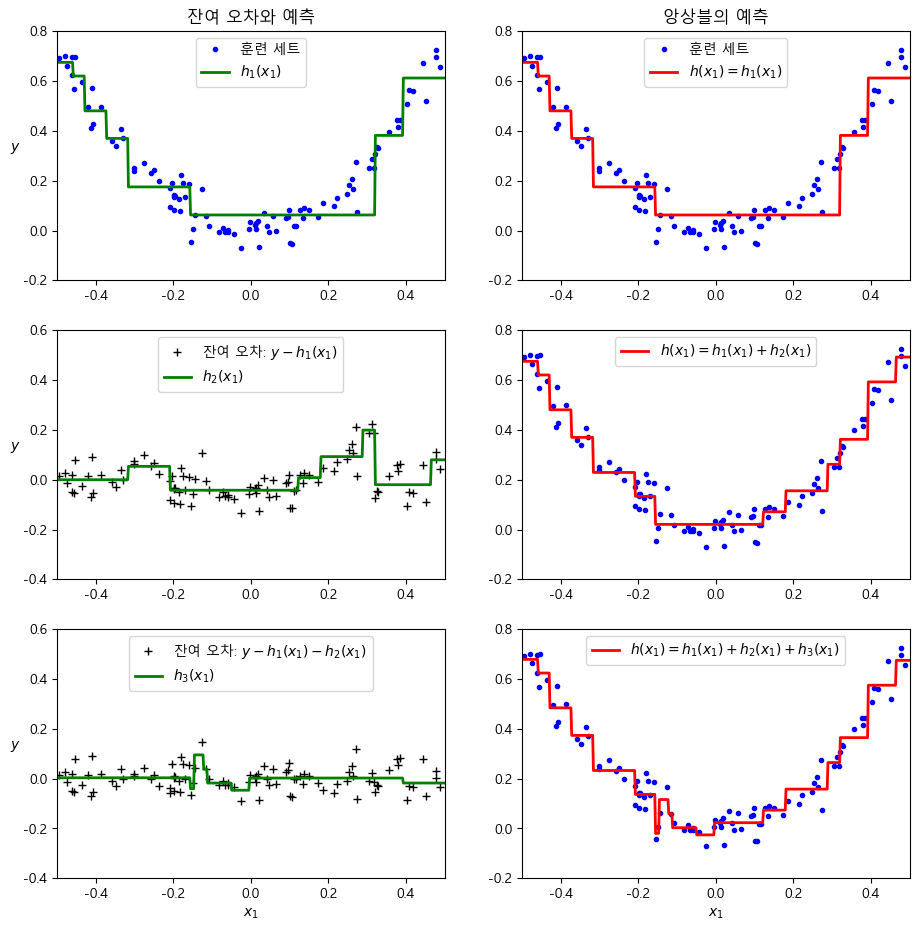

In [18]:
import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)    
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], x_, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], x_, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], x_, y_,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

#### GraientBoostingRegressor와의 비교

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# learning_rate: 각 트리의 기여 정도 (default = 1)
# 낮게 설정하면 훈련 데이터를 학습시키기 위해 많은 트리를 필요로 하게 된다.
gbr1 = GradientBoostingRegressor(max_depth=3, n_estimators=3, learning_rate=1, random_state=10)
gbr1.fit(x_, y_)

GradientBoostingRegressor(learning_rate=1, n_estimators=3, random_state=10)

In [20]:
# n_iter_no_chane: 조기 종료(Early Stopping)와 관련된 파라메터
# 지정된 횟수의 반복 동안 더이상 검증 점수 향상이 없으면 학습을 중단한다.
gbr2 = GradientBoostingRegressor(max_depth=3, n_estimators=500, learning_rate=0.05, random_state=11)
# gbr2 = GradientBoostingRegressor(max_depth=3, n_estimators=500, learning_rate=0.05, random_state=11, n_iter_no_change=11)
gbr2.fit(x_, y_)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=500, random_state=11)

In [21]:
print(gbr2.n_estimators_)

500


- 결과 시각화

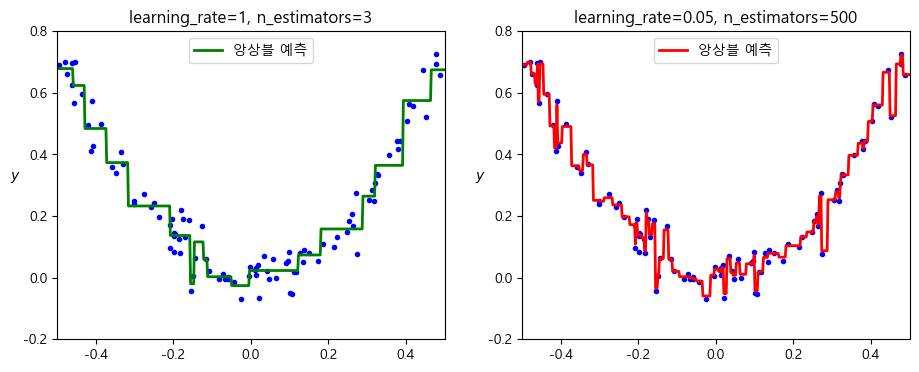

In [22]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
plot_predictions([gbr1], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="g-", label="앙상블 예측")
plt.ylabel("$y$  ", rotation=0)
plt.title(f'learning_rate={gbr1.learning_rate}, n_estimators={gbr1.n_estimators_}')

plt.subplot(1, 2, 2)
plot_predictions([gbr2], x_, y_, axes=[-0.5, 0.5, -0.2, 0.8], style="r-", label="앙상블 예측")
plt.ylabel("$y$  ", rotation=0)
plt.title(f'learning_rate={gbr2.learning_rate}, n_estimators={gbr2.n_estimators_}')

plt.show()

#### GradientBoostingRegressor

- 모델 생성 및 학습

In [23]:
gbr = GradientBoostingRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=300,
    n_iter_no_change=10,
    random_state=10
)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300,
                          n_iter_no_change=10, random_state=10)

- 모델 평가

In [24]:
y_hat = gbr.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.297
R2 Score:0.890


### XGBoost

In [25]:
!pip install xgboost

#### 파이썬 래퍼 XGBoost

- 패키지 로딩

In [26]:
import xgboost as xgb

- 학습데이터 검증 데이터 분리하기

In [27]:
# x_train, y_train을 분리해서 90%는 학습, 10%는 (매 반복 학습마다) 검증용으로 사용
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=10)

- DMatrix : XGBoost 전용 데이터 객체

In [28]:
feature_names = df.drop('MEDV', axis=1).columns
dtrain = xgb.DMatrix(x_train, y_train, feature_names=list(feature_names))
dtest = xgb.DMatrix(x_test, y_test, feature_names=list(feature_names))
dval = xgb.DMatrix(x_val, y_val, feature_names=list(feature_names))

- 모델 생성 및 학습

In [29]:
params = {
    'eval_metric':'rmse', # 성능평가지표
    'objective':'reg:squarederror', # 손실함수 지정
    'max_depth':3, # 의사결정나무의 깊이
    'eta':0.1 # 학습
}

In [30]:
# num_boost_round: 나무의 개수(반복 학습의 수)
# early_stopping_rounds: eval_metric 결과가 early_stopping_rounds 횟수 동안 개선되지 않으면 early_stopping_rounds에 도달하기 전에 조기 종료한다. (evals < 성능 평가를 위한 평가용 데이터 셋>과 함께 설정해야 함)
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=500, early_stopping_rounds=10, 
                      evals=[(dtrain,'train'), (dval,'eval')])

[0]	train-rmse:8.45604	eval-rmse:6.77447
[1]	train-rmse:7.81105	eval-rmse:6.33277
[2]	train-rmse:7.22947	eval-rmse:5.93251
[3]	train-rmse:6.72478	eval-rmse:5.64591
[4]	train-rmse:6.25765	eval-rmse:5.31793
[5]	train-rmse:5.85585	eval-rmse:5.10174
[6]	train-rmse:5.49278	eval-rmse:4.91791
[7]	train-rmse:5.12672	eval-rmse:4.68755
[8]	train-rmse:4.83821	eval-rmse:4.52721
[9]	train-rmse:4.54551	eval-rmse:4.36852
[10]	train-rmse:4.28768	eval-rmse:4.19689
[11]	train-rmse:4.05949	eval-rmse:4.08055
[12]	train-rmse:3.85760	eval-rmse:3.95697
[13]	train-rmse:3.67843	eval-rmse:3.85286
[14]	train-rmse:3.51753	eval-rmse:3.74871
[15]	train-rmse:3.36352	eval-rmse:3.68059
[16]	train-rmse:3.23409	eval-rmse:3.61263
[17]	train-rmse:3.11430	eval-rmse:3.56835
[18]	train-rmse:3.01372	eval-rmse:3.50601
[19]	train-rmse:2.92301	eval-rmse:3.45360
[20]	train-rmse:2.83922	eval-rmse:3.42702
[21]	train-rmse:2.76656	eval-rmse:3.39242
[22]	train-rmse:2.69625	eval-rmse:3.35036
[23]	train-rmse:2.63599	eval-rmse:3.34103
[2

- 모델 평가

In [31]:
y_hat = xgb_model.predict(dtest)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.356
R2 Score:0.886


- Feature Importance

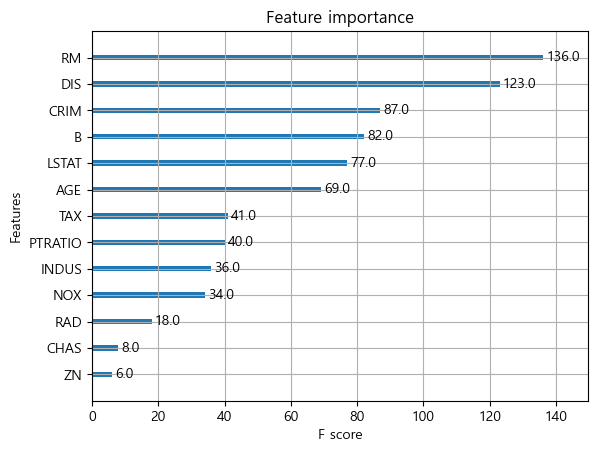

In [32]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model)
plt.show()

#### 사이킷런 래퍼 XGBoost

In [33]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=3)
evals = [(x_train, y_train), (x_val, y_val)]
xgb_reg.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='rmse', eval_set=evals, verbose=True)

[0]	validation_0-rmse:8.45604	validation_1-rmse:6.77447
[1]	validation_0-rmse:7.81105	validation_1-rmse:6.33277
[2]	validation_0-rmse:7.22947	validation_1-rmse:5.93251
[3]	validation_0-rmse:6.72478	validation_1-rmse:5.64591
[4]	validation_0-rmse:6.25765	validation_1-rmse:5.31793
[5]	validation_0-rmse:5.85585	validation_1-rmse:5.10174
[6]	validation_0-rmse:5.49278	validation_1-rmse:4.91791
[7]	validation_0-rmse:5.12672	validation_1-rmse:4.68755
[8]	validation_0-rmse:4.83821	validation_1-rmse:4.52721
[9]	validation_0-rmse:4.54551	validation_1-rmse:4.36852
[10]	validation_0-rmse:4.28768	validation_1-rmse:4.19689
[11]	validation_0-rmse:4.05949	validation_1-rmse:4.08055
[12]	validation_0-rmse:3.85760	validation_1-rmse:3.95697
[13]	validation_0-rmse:3.67843	validation_1-rmse:3.85286
[14]	validation_0-rmse:3.51753	validation_1-rmse:3.74871
[15]	validation_0-rmse:3.36352	validation_1-rmse:3.68059
[16]	validation_0-rmse:3.23409	validation_1-rmse:3.61263
[17]	validation_0-rmse:3.11430	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
y_hat = xgb_reg.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.352
R2 Score:0.886


### LightGBM (사이킷런 래퍼)

In [35]:
!pip install lightgbm

In [36]:
import lightgbm

In [37]:
from lightgbm import LGBMRegressor, early_stopping

In [38]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=10)

In [39]:
lgbm_reg = LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=3)
evals = [(x_train, y_train), (x_val, y_val)]
lgbm_reg.fit(x_train, y_train, eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=10)], eval_set=evals)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 326, number of used features: 13
[LightGBM] [Info] Start training from score 22.832822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

LGBMRegressor(max_depth=3, n_estimators=500)

In [40]:
y_hat = lgbm_reg.predict(x_test)
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score:{r2_score(y_test, y_hat):.3f}')

RMSE:3.587
R2 Score:0.870


# 앙상블 분류

## (공통) 데이터 로딩 및 분할

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score  # 분류 모형
from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd

In [45]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
print(df.shape)
display(df.head())

x = df
y = cancer.target

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0, stratify=y)

## Voting

### 패키지 로딩

In [47]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB  # 데이터가 모두 수치형이기 때문에

### 모델 생성
- voting: hard, soft 값 사용 (default = hard)

In [49]:
logistic = LogisticRegression(max_iter=4000)
knn = KNeighborsClassifier(n_neighbors=3)
nb = GaussianNB()

vo_c = VotingClassifier(estimators=[('Logistic', logistic), ('KNN', knn), ('Naive_Bayes', nb)], voting='soft')

### 학습 및 평가

In [54]:
vo_c.fit(x_train, y_train) 
y_hat = vo_c.predict(x_test)

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, vo_c.predict_proba(x_test)[:,1]):.3f}')
# voting = hard 일 경우, predict_proba 결과 도출 불가

정확도:0.956
AUC:0.988


### 개별 분류모형 학습결과 비교

In [53]:
estimators = [('Logistic', logistic), ('KNN', knn), ('Naive_Bayes', nb)]
for name, model in estimators:
    model.fit(x_train, y_train) 
    y_hat = model.predict(x_test)

    print(f'{name} 모델 정확도:{accuracy_score(y_test, y_hat):.3f}')
    print(f'{name} 모델 AUC:{roc_auc_score(y_test, model.predict_proba(x_test)[:,1]):.3f}')
    print('='*40)

Logistic 모델 정확도:0.947
Logistic 모델 AUC:0.994
KNN 모델 정확도:0.904
KNN 모델 AUC:0.931
Naive_Bayes 모델 정확도:0.921
Naive_Bayes 모델 AUC:0.971


## Boosting

### AdaBoost

#### 패키지 로딩

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#### 모델 생성

In [56]:
boo_c = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=300, random_state=0)

#### 학습 및 평가

In [57]:
boo_c.fit(x_train, y_train) 
y_hat = boo_c.predict(x_test)

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, boo_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.921
AUC:0.969


### GradientBoost

#### 패키지 로딩

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

#### 모델 생성 및 학습

In [59]:
gb_c = GradientBoostingClassifier(random_state=0)
gb_c.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

#### 예측 및 평가

In [60]:
y_hat = gb_c.predict(x_test)

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, gb_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.939
AUC:0.983


#### 하이퍼 파라메터 튜닝

In [62]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[200, 300],
    'max_depth': [3, 6, 8],
    'min_samples_split': [2, 3, 5, 10],
    'learning_rate': [0.05, 0.1, 0.2]
}
gb_grid = GridSearchCV(gb_c, params, cv=5, scoring='accuracy', n_jobs=1)
gb_grid.fit(x,y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 8],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [200, 300]},
             scoring='accuracy')

In [63]:
print('최적 파라메터:', gb_grid.best_params_)
print(f'평균 정확도:{gb_grid.best_score_}')

최적 파라메터: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
평균 정확도:0.9666200900481291


In [64]:
estimator = gb_grid.best_estimator_
y_hat = estimator.predict(x_test)

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, estimator.predict_proba(x_test)[:,1]):.3f}')

정확도:1.000
AUC:1.000


### XGBoost (사이킷런 래퍼)

In [65]:
# 학습 데이터로부터 10%의 검증용 데이터를 분리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=10, stratify=y_train)

In [66]:
from xgboost import XGBClassifier

xgb_c = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3)
evals = [(x_train, y_train), (x_val, y_val)]
# logloss: 분류 문제에 사용되는 손실함수, cross-entropy error 라고도 한다.
xgb_c.fit(x_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True) 

[0]	validation_0-logloss:0.61923	validation_1-logloss:0.61948
[1]	validation_0-logloss:0.58053	validation_1-logloss:0.58305
[2]	validation_0-logloss:0.54534	validation_1-logloss:0.55370
[3]	validation_0-logloss:0.51389	validation_1-logloss:0.52113
[4]	validation_0-logloss:0.48530	validation_1-logloss:0.49310
[5]	validation_0-logloss:0.45874	validation_1-logloss:0.46579
[6]	validation_0-logloss:0.43370	validation_1-logloss:0.44091
[7]	validation_0-logloss:0.41069	validation_1-logloss:0.41915
[8]	validation_0-logloss:0.38922	validation_1-logloss:0.39796
[9]	validation_0-logloss:0.36941	validation_1-logloss:0.37939
[10]	validation_0-logloss:0.35081	validation_1-logloss:0.36119
[11]	validation_0-logloss:0.33279	validation_1-logloss:0.34625
[12]	validation_0-logloss:0.31601	validation_1-logloss:0.33248
[13]	validation_0-logloss:0.30094	validation_1-logloss:0.31754
[14]	validation_0-logloss:0.28690	validation_1-logloss:0.30363
[15]	validation_0-logloss:0.27318	validation_1-logloss:0.29217
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
y_hat = xgb_c.predict(x_test)

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, xgb_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.956
AUC:0.977


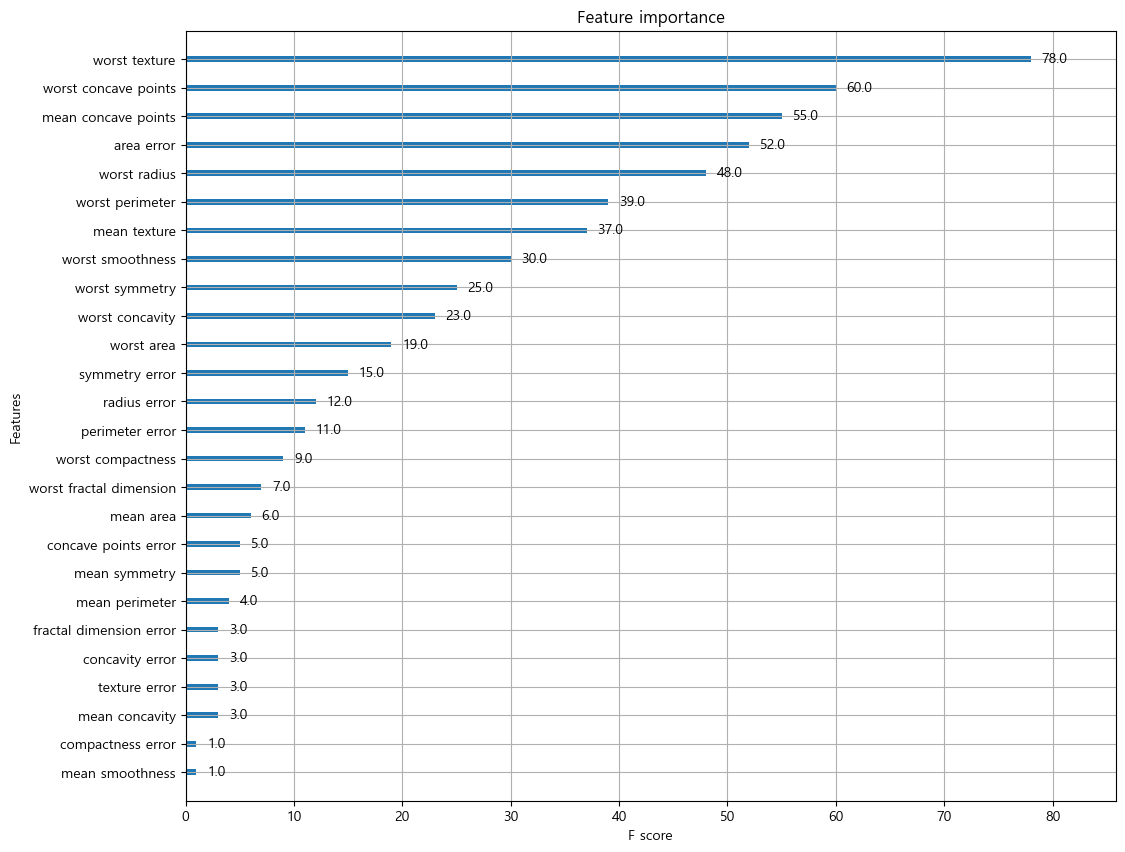

In [69]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgb_c, ax=ax)
plt.show()

### LightGBM (사이킷런 래퍼)

In [71]:
from lightgbm import LGBMClassifier, early_stopping

lgbm_c = LGBMClassifier(n_estimators=300, learning_rate=0.05)
evals = [(x_train, y_train), (x_val, y_val)]
callbacks = [early_stopping(stopping_rounds=10)]
lgbm_c.fit(x_train, y_train, eval_metric='logloss', callbacks=callbacks, eval_set=evals)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 256, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625917 -> initscore=0.514740
[LightGBM] [Info] Start training from score 0.514740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(learning_rate=0.05, n_estimators=300)

In [72]:
y_hat = lgbm_c.predict(x_test)

print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, lgbm_c.predict_proba(x_test)[:,1]):.3f}')

정확도:0.939
AUC:0.973


## Stacking

### 패키지 로딩

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression   # 2nd meta model (최종 학습할 모델)

### 모델 생성

In [74]:
knn_1st = KNeighborsClassifier(n_neighbors=3)
rf_1st = RandomForestClassifier(random_state=0)
dt_1st = DecisionTreeClassifier()
ada_1st = AdaBoostClassifier(n_estimators=200)

lr_final = LogisticRegression()

### 학습 및 평가

In [75]:
knn_1st.fit(x_train, y_train)
rf_1st.fit(x_train, y_train)
dt_1st.fit(x_train, y_train)
ada_1st.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=200)

In [76]:
knn_pred = knn_1st.predict(x_test)
rf_pred = rf_1st.predict(x_test)
dt_pred = dt_1st.predict(x_test)
ada_pred = ada_1st.predict(x_test)

### 스태킹(Stacking)

In [80]:
print(knn_pred.shape)
y_hat = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(y_hat.shape)
y_hat = np.transpose(y_hat)  # 열과 행 위치 변경
print(y_hat.shape)

(114,)
(4, 114)
(114, 4)


### 메타 모델 학습 및 평가

In [85]:
lr_final.fit(y_hat, y_test)
final_y_hat = lr_final.predict(y_hat)
print(f'최종 메타 모델의 예측 정확도:{accuracy_score(y_test, final_y_hat):.3f}')

최종 메타 모델의 예측 정확도:0.974


## [실습] 인도 대학교 취업지원 결과 예측
- 데이터 구조
>- sl_no: serial number
>- gender: 성별 (값: M=Male, F=Fmale)
>- ssc_p: 중등교육 시험 평균점수 (10학년)
>- ssc_b: 소속 중등교육 위원회 (값: Central, Others)
>- hsc_p: 고등 중등 교육 시험 평균점수 (12학년)
>- hsc_b: 소속 고등 중등 교육 위원회 (값: Central, Others)
>- hsc_s: 고등 중등 교육의 전문화 (값: Commerce(상업계), Science(과학계), Arts(예술계))
>- degree_p: 학부 과정의 최종 평균 점수
>- degree_t: 학위 분야 (값: Comm&Mgmt(상업 및 관리), Sci&Tech(과학 및 기술), Others(기타))
>- workex: 일 경험 여부 (값: Yes. No)
>- etest_p : 취업 적성 시험 점수
>- specialisation: 전문화 과정 (값: Mkt&HR(마케팅 및 HR), Mkt&Fin(마케팅 및 재무))
>- mba_p: 경영학 과정의 석사학위 최종 평균 점수
>- status: 취업 여부 (값: Placed(배정), Not Placed(미배정))
>- salary: 급여 (취업이 배정된 경우)
- 처리조건
>- 범주형 피처에 대한 one-hot encoding
>- 시리얼, 급여 피처는 학습 대상에서 제외
>- 최소 2개 이상의 이진분류 알고리즘으로 학습하고 각 모델의 결과 비교 

### 패키지 로딩

In [201]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### 데이터 로딩 및 확인

In [202]:
df_job = pd.read_csv('./dataset/Placement_Data_Full_Class.csv')
display(df_job.head())
print(df_job.shape)
print(df_job.info())

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


(215, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB
None


In [203]:
print(df_job['ssc_b'].unique())

['Others' 'Central']


### 데이터 전처리

In [204]:
df_job.drop(['sl_no', 'salary'], axis = 1, inplace = True)

In [205]:
# 사이킷런을 이용한 라벨 인코딩
df_job2 = df_job.copy()
df_job2 = df_job2.apply(lambda col:LabelEncoder().fit_transform(col) if col.dtype == object else col)

display(df_job2.head())

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,1
1,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,1
2,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,1
3,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,0
4,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,1


In [206]:
# pandas를 이용한 원-핫 인코딩
df_job3 = df_job.copy()
cols = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
df_job3 = pd.get_dummies(df_job3, columns = cols)

display(df_job3.head())

,ssc_p,hsc_p,degree_p,etest_p,mba_p,status,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,67.00,91.00,58.00,55.0,58.80,Placed,False,True,False,True,...,False,True,False,False,False,True,True,False,False,True
1,79.33,78.33,77.48,86.5,66.28,Placed,False,True,True,False,...,False,False,True,False,False,True,False,True,True,False
2,65.00,68.00,64.00,75.0,57.80,Placed,False,True,True,False,...,True,False,False,True,False,False,True,False,True,False
3,56.00,52.00,52.00,66.0,59.43,Not Placed,False,True,True,False,...,False,False,True,False,False,True,True,False,False,True
4,85.80,73.60,73.30,96.8,55.50,Placed,False,True,True,False,...,False,True,False,True,False,False,True,False,True,False


In [207]:
df_job3['status'] = df_job3['status'].map({'Not Placed':0, 'Placed':1})
display(df_job3.head())

,ssc_p,hsc_p,degree_p,etest_p,mba_p,status,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,67.00,91.00,58.00,55.0,58.80,1,False,True,False,True,...,False,True,False,False,False,True,True,False,False,True
1,79.33,78.33,77.48,86.5,66.28,1,False,True,True,False,...,False,False,True,False,False,True,False,True,True,False
2,65.00,68.00,64.00,75.0,57.80,1,False,True,True,False,...,True,False,False,True,False,False,True,False,True,False
3,56.00,52.00,52.00,66.0,59.43,0,False,True,True,False,...,False,False,True,False,False,True,True,False,False,True
4,85.80,73.60,73.30,96.8,55.50,1,False,True,True,False,...,False,True,False,True,False,False,True,False,True,False


### 데이터 분리

In [208]:
x = df_job3.drop('status', axis = 1)
y = df_job3['status']

In [209]:
x_train, x_test, y_train, y_test = train_test_split(x, y ,random_state = 0, train_size = 0.8, stratify = y)

### 학습 및 평가

In [210]:
model = LogisticRegression(max_iter = 2000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=2000)

In [211]:
y_hat = model.predict(x_test)
cm = confusion_matrix(y_test, y_hat)
print(cm)
print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]):.3f}')

[[10  3]
 [ 3 27]]
정확도: 0.860
AUC: 0.928


# GradientBoostingClassifier

In [212]:
from sklearn.ensemble import GradientBoostingRegressor

In [213]:
gbc = GradientBoostingClassifier(n_estimators=200)
gbc.fit(x_train, y_train)

GradientBoostingClassifier(n_estimators=200)

In [214]:
y_hat = gbc.predict(x_test)
cm = confusion_matrix(y_test, y_hat)
print(cm)
print(f'정확도: {accuracy_score(y_test, y_hat):.3f}')
print(f'AUC: {roc_auc_score(y_test, gbc.predict_proba(x_test)[:, 1]):.3f}')

[[ 9  4]
 [ 2 28]]
정확도: 0.860
AUC: 0.913


# [실습] 비행기 연착 추측 분류

## 패키지 로딩 

In [252]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## 데이터 로딩 및 확인

In [253]:
df_airport = pd.read_csv('./dataset/Airport Codes Dataset.csv')
print(df_airport.shape)
display(df_airport.head())
df_airport.info()

(365, 4)


,airport_id,city,state,name
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   airport_id  365 non-null    int64 
 1   city        365 non-null    object
 2   state       365 non-null    object
 3   name        365 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.5+ KB


In [254]:
df_flight = pd.read_csv('./dataset/Flight on-time performance.csv')
print(df_flight.shape)
display(df_flight.head())

(504397, 18)


,Year,Quarter,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepTimeBlk,DepDelay,DepDel15,CRSArrTime,ArrTimeBlk,ArrDelay,ArrDel15,Cancelled,Diverted
0,2011,4,10,6,4,WN,13495,12191,1435,1400-1459,2.0,0.0,1550,1500-1559,-6.0,0.0,0,0
1,2011,4,10,6,4,WN,13495,12191,1330,1300-1359,-4.0,0.0,1445,1400-1459,-12.0,0.0,0,0
2,2011,4,10,6,4,WN,13495,12191,1030,1000-1059,-2.0,0.0,1145,1100-1159,-14.0,0.0,0,0
3,2011,4,10,6,4,WN,13495,12889,1900,1900-1959,0.0,0.0,2055,2000-2059,-6.0,0.0,0,0
4,2011,4,10,6,4,WN,13495,12889,1340,1300-1359,-1.0,0.0,1530,1500-1559,2.0,0.0,0,0


In [256]:
# 결측치 확인
print(df_airport.isna().sum())
print()
print(df_flight.isna().sum())

airport_id    0
city          0
state         0
name          0
dtype: int64

Year                  0
Quarter               0
Month                 0
DayofMonth            0
DayOfWeek             0
Carrier               0
OriginAirportID       0
DestAirportID         0
CRSDepTime            0
DepTimeBlk            0
DepDelay           3697
DepDel15           3697
CRSArrTime            0
ArrTimeBlk            0
ArrDelay           4717
ArrDel15           4717
Cancelled             0
Diverted              0
dtype: int64


## 데이터 전처리

### 공항정보 데이터의 컬럼 이름을 출발 공항으로 변경

In [257]:
# 공항정보 데이터의 city, state, name 컬럼명을 Ori-city, Ori-state, Ori-airport로 변경(원본 데이터 유지)
df_ori_airport = df_airport.rename(columns= {'city':'Ori-city', 'state':'Ori-state', 'name':'Ori-airport'}, inplace=False)
display(df_ori_airport.head())

,airport_id,Ori-city,Ori-state,Ori-airport
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport


### 비행정보 데이터와 출발공항 정보 데이터 병합

In [258]:
# 비행정보 데이터의 “출발공항ID” 컬럼과 공항정보 데이터의 “공항ID”컬럼을 키 값으로 두 데이터 조인
merged_df1 = pd.merge(df_flight, df_ori_airport, left_on='OriginAirportID', right_on='airport_id')

In [259]:
print(merged_df1.shape)
display(merged_df1.head())

(504397, 22)


,Year,Quarter,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepTimeBlk,...,CRSArrTime,ArrTimeBlk,ArrDelay,ArrDel15,Cancelled,Diverted,airport_id,Ori-city,Ori-state,Ori-airport
0,2011,4,10,6,4,WN,13495,12191,1435,1400-1459,...,1550,1500-1559,-6.0,0.0,0,0,13495,New Orleans,LA,Louis Armstrong New Orleans International
1,2011,4,10,6,4,WN,13495,12191,1330,1300-1359,...,1445,1400-1459,-12.0,0.0,0,0,13495,New Orleans,LA,Louis Armstrong New Orleans International
2,2011,4,10,6,4,WN,13495,12191,1030,1000-1059,...,1145,1100-1159,-14.0,0.0,0,0,13495,New Orleans,LA,Louis Armstrong New Orleans International
3,2011,4,10,6,4,WN,13495,12889,1900,1900-1959,...,2055,2000-2059,-6.0,0.0,0,0,13495,New Orleans,LA,Louis Armstrong New Orleans International
4,2011,4,10,6,4,WN,13495,12889,1340,1300-1359,...,1530,1500-1559,2.0,0.0,0,0,13495,New Orleans,LA,Louis Armstrong New Orleans International


In [260]:
# 중복된 출발 공항 ID 컬럼 삭제
merged_df1.drop('airport_id', axis=1, inplace=True)

### 공항정보 데이터의 칼럼의 이름을 도착 공항으로 변경

In [261]:
# 공항정보 데이터의 city, state, name 컬럼명을 Dest-city, Dest-state, Dest-airport로 변경(원본 데이터 유지)
df_dest_airport = df_airport.rename(columns= {'city':'Dest-city', 'state':'Dest-state', 'name':'Dest-airport'})
display(df_dest_airport)

,airport_id,Dest-city,Dest-state,Dest-airport
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport
...,...,...,...,...
360,11233,Cheyenne,WY,Cheyenne Regional/Jerry Olson Field
361,11097,Cody,WY,Yellowstone Regional
362,11865,Gillette,WY,Gillette Campbell County
363,12441,Jackson,WY,Jackson Hole


### 1차 병합된 비행정보 데이터와 도착공항 정보 데이터 병합

In [262]:
# 비행정보 데이터의 “도착공항ID” 컬럼과 공항정보 데이터의 “공항ID”컬럼을 키 값으로 두 데이터 조인
merged_df2 = pd.merge(merged_df1, df_dest_airport, left_on='DestAirportID', right_on='airport_id')
print(merged_df2.shape)
display(merged_df2.head())

(504397, 25)


,Year,Quarter,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepTimeBlk,...,ArrDel15,Cancelled,Diverted,Ori-city,Ori-state,Ori-airport,airport_id,Dest-city,Dest-state,Dest-airport
0,2011,4,10,6,4,WN,13495,12191,1435,1400-1459,...,0.0,0,0,New Orleans,LA,Louis Armstrong New Orleans International,12191,Houston,TX,William P Hobby
1,2011,4,10,6,4,WN,13495,12191,1330,1300-1359,...,0.0,0,0,New Orleans,LA,Louis Armstrong New Orleans International,12191,Houston,TX,William P Hobby
2,2011,4,10,6,4,WN,13495,12191,1030,1000-1059,...,0.0,0,0,New Orleans,LA,Louis Armstrong New Orleans International,12191,Houston,TX,William P Hobby
3,2011,4,10,7,5,WN,13495,12191,820,0800-0859,...,0.0,0,0,New Orleans,LA,Louis Armstrong New Orleans International,12191,Houston,TX,William P Hobby
4,2011,4,10,7,5,WN,13495,12191,1205,1200-1259,...,0.0,0,0,New Orleans,LA,Louis Armstrong New Orleans International,12191,Houston,TX,William P Hobby


In [263]:
# 중복된 도착 공항 ID 컬럼 삭제
merged_df2.drop('airport_id', axis=1, inplace=True)

### 24개 컬럼 중 학습에 사용할 14개 컬럼만 선택

In [264]:
print(merged_df2.columns)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Carrier',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTimeBlk',
       'DepDelay', 'DepDel15', 'CRSArrTime', 'ArrTimeBlk', 'ArrDelay',
       'ArrDel15', 'Cancelled', 'Diverted', 'Ori-city', 'Ori-state',
       'Ori-airport', 'Dest-city', 'Dest-state', 'Dest-airport'],
      dtype='object')


In [266]:
df_flight_info = merged_df2[['DayOfWeek', 'Carrier', 'DepTimeBlk', 'DepDelay', 'DepDel15', 'ArrTimeBlk', 'ArrDel15',
'Ori-city', 'Ori-state', 'Ori-airport', 'Dest-city', 'Dest-state', 'Dest-airport', 'ArrDelay']]
df_flight_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504397 entries, 0 to 504396
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DayOfWeek     504397 non-null  int64  
 1   Carrier       504397 non-null  object 
 2   DepTimeBlk    504397 non-null  object 
 3   DepDelay      500700 non-null  float64
 4   DepDel15      500700 non-null  float64
 5   ArrTimeBlk    504397 non-null  object 
 6   ArrDel15      499680 non-null  float64
 7   Ori-city      504397 non-null  object 
 8   Ori-state     504397 non-null  object 
 9   Ori-airport   504397 non-null  object 
 10  Dest-city     504397 non-null  object 
 11  Dest-state    504397 non-null  object 
 12  Dest-airport  504397 non-null  object 
 13  ArrDelay      499680 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 53.9+ MB


### 결측 데이터 처리

In [267]:
df_flight_info = df_flight_info.dropna()

### 범주형 데이터 인코딩

In [270]:
for col in [col for col in df_flight_info.columns if df_flight_info[col].dtype == 'object']:
    print(f'컬럼명:{col:<15s}, 유니크 값 개수: {df_flight_info[col].unique().size}')

컬럼명:Carrier        , 유니크 값 개수: 16
컬럼명:DepTimeBlk     , 유니크 값 개수: 19
컬럼명:ArrTimeBlk     , 유니크 값 개수: 19
컬럼명:Ori-city       , 유니크 값 개수: 268
컬럼명:Ori-state      , 유니크 값 개수: 53
컬럼명:Ori-airport    , 유니크 값 개수: 279
컬럼명:Dest-city      , 유니크 값 개수: 268
컬럼명:Dest-state     , 유니크 값 개수: 53
컬럼명:Dest-airport   , 유니크 값 개수: 279


### 라벨 인코딩

In [272]:
encoder = LabelEncoder()
df_flight_info = df_flight_info.apply(lambda col:encoder.fit_transform(col) if col.dtype == 'object' else col)

In [273]:
print(df_flight_info.info())

<class 'pandas.core.frame.DataFrame'>
Index: 499680 entries, 0 to 504396
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DayOfWeek     499680 non-null  int64  
 1   Carrier       499680 non-null  int32  
 2   DepTimeBlk    499680 non-null  int32  
 3   DepDelay      499680 non-null  float64
 4   DepDel15      499680 non-null  float64
 5   ArrTimeBlk    499680 non-null  int32  
 6   ArrDel15      499680 non-null  float64
 7   Ori-city      499680 non-null  int32  
 8   Ori-state     499680 non-null  int32  
 9   Ori-airport   499680 non-null  int32  
 10  Dest-city     499680 non-null  int32  
 11  Dest-state    499680 non-null  int32  
 12  Dest-airport  499680 non-null  int32  
 13  ArrDelay      499680 non-null  float64
dtypes: float64(4), int32(9), int64(1)
memory usage: 40.0 MB
None


## 데이터 분할

In [274]:
x = df_flight_info.drop('ArrDel15', axis=1)
y = df_flight_info['ArrDel15']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0, stratify=y)

## 모델 학습 및 평가

In [275]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [280]:
model = LogisticRegression(solver='sag', max_iter=2000)   # 확률적경사하강법 사용 (대용량 데이터 처리 특징)
model.fit(x_train, y_train)

LogisticRegression(max_iter=2000, solver='sag')

In [281]:
y_hat = model.predict(x_test)
print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
print(f'AUC:{roc_auc_score(y_test, model.predict_proba(x_test)[:,1]):.3f}')

정확도:0.984
AUC:0.998


## Feature Importance

In [278]:
importance = { k:v for k, v in zip(x.columns, model.feature_importances_) }
df_importance = pd.DataFrame(pd.Series(importance), columns=['Importance']).sort_values('Importance', ascending=False)
display(df_importance)

,Importance
ArrDelay,0.637359
DepDelay,0.235822
DepDel15,0.114842
DepTimeBlk,0.002697
ArrTimeBlk,0.001804
Carrier,0.001721
DayOfWeek,0.000992
Dest-airport,0.000892
Dest-state,0.000840
Ori-city,0.000790


## 회귀계수(가중치)

In [283]:
weight = { k:v for k, v in zip(x.columns, model.coef_.squeeze(axis=0)) }
df_weight = pd.DataFrame(pd.Series(weight), columns=['가중치']).sort_values('가중치', ascending=False)
display(df_weight)

,가중치
ArrDelay,0.647084
DepDelay,0.025836
DepDel15,0.006562
Dest-city,-0.001131
Ori-city,-0.001268
Dest-airport,-0.010010
Ori-airport,-0.010022
DepTimeBlk,-0.038278
Dest-state,-0.038360
Ori-state,-0.044370
